# Text Classification on Sogou News Corpus

基于搜狗新闻语料的文本分类过程

文本分类（Text Classification）是自然语言处理中的一个重要应用技术，根据文档的内容或主题，自动识别文档所属的预先定义的类别标签。文本分类是很多应用场景的基础，比如垃圾邮件识别，舆情分析，情感识别，新闻自动分类，智能客服机器人的知识库分类等等。本文用标注好的搜狗新闻语料，基于scikit-learn机器学习Python库，将文本分类的完整过程实现一遍。

本文语料：搜狗分类新闻.20061127.zip

更多新闻标注语料，[下载链接](http://www.sogou.com/labs/resource/list_news.php)

中文文本分类主要分为以下步骤：
1. 语料预处理
2. 生成训练集和测试集
3. 文本特征提取:TF-IDF
4. 构建分类器
5. 分类器的评估


## 1. 语料预处理

首先加载所有需要用到的Python库

In [1]:
import os
import shutil
import re
import jieba

import numpy as np 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

定义搜狗新闻文本标签的名称，`C000008`这样的标签是语料的子目录，在网上搜到标签对应的新闻类别，为了便于理解，定义了这个映射词典，并保留原有编号信息。原始语料的目录结构：
```
CN_Corpus
└─SogouC.reduced
    └─Reduced
        ├─C000008
        ├─C000010
        ├─C000013
        ├─C000014
        ├─C000016
        ├─C000020
        ├─C000022
        ├─C000023
        └─C000024
```

In [2]:
category_labels = {
    'C000008': '_08_Finance',
    'C000010': '_10_IT',
    'C000013': '_13_Health',
    'C000014': '_14_Sports',
    'C000016': '_16_Travel',
    'C000020': '_20_Education',
    'C000022': '_22_Recruit',
    'C000023': '_23_Culture',
    'C000024': '_24_Military'
}

下面进行语料的切分，将每个类别的前80%作为训练语料，后20%作为测试语料。切分完之后的语料目录如下：
```
data
├─test
│  ├─_08_Finance
│  ├─_10_IT
│  ├─_13_Health
│  ├─_14_Sports
│  ├─_16_Travel
│  ├─_20_Education
│  ├─_22_Recruit
│  ├─_23_Culture
│  └─_24_Military
└─train
    ├─_08_Finance
    ├─_10_IT
    ├─_13_Health
    ├─_14_Sports
    ├─_16_Travel
    ├─_20_Education
    ├─_22_Recruit
    ├─_23_Culture
    └─_24_Military
```

In [3]:
def split_corpus():
    # original data directory
    original_dataset_dir = './CN_Corpus/SogouC.reduced/Reduced'
    base_dir = 'data/'

    if (os.path.exists(base_dir)):
        print('`data` seems already exist.')
        return
    
    # make new folders
    os.mkdir(base_dir)
    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)
    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)

    # split corpus
    for cate in os.listdir(original_dataset_dir):
        cate_dir = os.path.join(original_dataset_dir, cate)
        file_list = os.listdir(cate_dir)
        print("cate: {}, len: {}".format(cate, len(file_list)))

        # train data
        fnames = file_list[:1500] 
        dst_dir = os.path.join(train_dir, category_labels[cate])
        os.mkdir(dst_dir)
        print("dst_dir: {}, len: {}".format(dst_dir, len(fnames)))
        for fname in fnames:
            src = os.path.join(cate_dir, fname)
            dst = os.path.join(dst_dir, fname)
            shutil.copyfile(src, dst)

        # test data
        fnames = file_list[1500:] 
        dst_dir = os.path.join(test_dir, category_labels[cate])
        os.mkdir(dst_dir)
        print("dst_dir: {}, len: {}".format(dst_dir, len(fnames)))
        for fname in fnames:
            src = os.path.join(cate_dir, fname)
            dst = os.path.join(dst_dir, fname)
            shutil.copyfile(src, dst)
    print('Corpus split DONE.')

split_corpus()

cate: C000008, len: 1990
dst_dir: data/train\_08_Finance, len: 1500
dst_dir: data/test\_08_Finance, len: 490
cate: C000010, len: 1990
dst_dir: data/train\_10_IT, len: 1500
dst_dir: data/test\_10_IT, len: 490
cate: C000013, len: 1990
dst_dir: data/train\_13_Health, len: 1500
dst_dir: data/test\_13_Health, len: 490
cate: C000014, len: 1990
dst_dir: data/train\_14_Sports, len: 1500
dst_dir: data/test\_14_Sports, len: 490
cate: C000016, len: 1990
dst_dir: data/train\_16_Travel, len: 1500
dst_dir: data/test\_16_Travel, len: 490
cate: C000020, len: 1990
dst_dir: data/train\_20_Education, len: 1500
dst_dir: data/test\_20_Education, len: 490
cate: C000022, len: 1990
dst_dir: data/train\_22_Recruit, len: 1500
dst_dir: data/test\_22_Recruit, len: 490
cate: C000023, len: 1990
dst_dir: data/train\_23_Culture, len: 1500
dst_dir: data/test\_23_Culture, len: 490
cate: C000024, len: 1990
dst_dir: data/train\_24_Military, len: 1500
dst_dir: data/test\_24_Military, len: 490
Corpus split DONE.


## 2. 生成训练集和测试集

### 中文分词
定义一个分词预处理函数，采用`jieba`分词工具，主要去掉对文本分类无用的标点符号和数字，输入为新闻文本，输出为分词之后并用空格连接的文本。

In [4]:
token = "[0-9\s+\.\!\/_,$%^*()?;；：【】+\"\'\[\]\\]+|[+——！，;:。？《》、~@#￥%……&*（）“”.=-]+"

def preprocess(text):
    text1 = re.sub('&nbsp', ' ', text)
    str_no_punctuation = re.sub(token, ' ', text1)  # 去掉标点
    text_list = list(jieba.cut(str_no_punctuation))   # 分词列表
    text_list = [item for item in text_list if item != ' '] # 去掉空格
    return ' '.join(text_list)

### 生成数据集

从上面切分好的语料目录中读取文本并进行分词预处理，输出：训练语料数据(`X_train_data`)、训练语料标签(`y_train`)、测试语料数据(`X_test_data`)、测试语料标签(`y_test`)。

In [ ]:
def load_datasets():
    base_dir = 'data/'
    X_data = {'train':[], 'test':[]}
    y = {'train':[], 'test':[]}
    for type_name in ['train', 'test']:
        corpus_dir = os.path.join(base_dir, type_name)
        corpus_list = []
        for label in os.listdir(corpus_dir):
            label_dir = os.path.join(corpus_dir, label)
            file_list = os.listdir(label_dir)
            print("label: {}, len: {}".format(label, len(file_list)))

            for fname in file_list:
                file_path = os.path.join(label_dir, fname)
                with open(file_path, encoding='gb2312', errors='ignore') as text_file:
                    text_content = preprocess(text_file.read())
                X_data[type_name].append(text_content)
                y[type_name].append(label)

        print("{} corpus len: {}\n".format(type_name, len(X_data[type_name])))
    
    return X_data['train'], y['train'], X_data['test'], y['test']

X_train_data, y_train, X_test_data, y_test = load_datasets()

数据集的形式如下：

In [6]:
X_train_data[1000]

'新华网 上海 月 日电 记者 黄庭钧 继 日 人民币 兑 美元 中间价 突破 关口 创 历史 新高 后 日 人民币 兑 美元汇率 继续 攀升 中国外汇交易中心 日 公布 的 中间价 为 再刷 历史 新高 大有 逼近 和 突破 心理 关口 之势 据 兴业银行 资金 营运 中心 交易员 余屹 介绍 人民币 兑 美元汇率 日 走势 继续 表现 强劲 竞价 交易 以 开盘 后 最低 曾 回到 最高 则 触及 距 关口 仅 一步之遥 收报 而 询价 交易 亦 表现 不俗 以 开盘 后 曾经 走低 到 最高 仅触 到 截至 时 分 报收 虽然 全日 波幅 较窄 但 均 在 下方 有 跃跃欲试 关口 之 态势 完'

In [7]:
y_train[1000]

'_08_Finance'

### 词云显示

这里插一个与文本分类无关的步骤，用WordCloud展示文本的词频信息，直观看一下文本关键词信息，生成的词云图片可以让人一目了然。如果让人来进行分类，扫一眼词云就可以在很短时间内做出分类判断，比阅读原始文本要快的多，其原理就是利用了文本中的高频词信息，频率高的词（去除停用词之后）比较能代表文本的主旨信息，其实后面的分类过程大概就是这个思路。WordCloud默认不显示中文字体，会显示成方块，可以在网上下载字体文件simhei.ttf，放在当前目录下即可。

(-0.5, 1599.5, 799.5, -0.5)

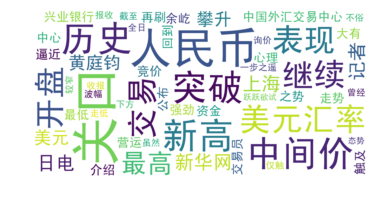

In [8]:
wordcloud = WordCloud(scale=4,
                      font_path='simhei.ttf',
                      background_color='white',
                      max_words = 100,
                      max_font_size = 60,
                      random_state=20).generate(X_train_data[1000])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

## 3. 文本特征提取:TF-IDF

这个步骤将文档信息，也即每篇新闻被分好词之后的词集合，转为为基于词频-你文档词频（TF-IDF）的向量，向量的每个元素都是对应于某个词在这个文档中的TF-IDF值，在不同文档中，同一词的TF-IDF是不一样的。所有文档的TF-IDF向量堆放在一起就组成了一个TF-IDF矩阵。注意到这里应该包含了除停用词之外的所有词的TF-IDF值，词的个数构成了向量的维度。   

用`TfidfVectorizer`将文档集合转为`TF-IDF`矩阵。注意到前面我们将文本做了分词并用空格隔开。如果是英文，本身就是空格隔开的，而英文的分词（Tokenizing）是包含在特征提取器中的，不需要分词这一步骤。下面我们在得到了分类器之后，使用新文本进行分类预测时，也是需要先做一下中文分词的。

In [9]:
stopwords = open('dict/stop_words.txt', encoding='utf-8').read().split()

# TF-IDF feature extraction
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_data)
words = tfidf_vectorizer.get_feature_names()

In [10]:
X_train_tfidf.shape

(13500, 223094)

In [11]:
len(words)

223094

## 4. 构建分类器

### Benchmark: 朴素贝叶斯分类器

得到了训练样本的文本特征，现在可以训练出一个分类器，以用来对新的新闻文本进行分类。`scikit-learn`中提供了多种分类器，其中[朴素贝叶斯](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes)是一个很好的基准，有多个版本的朴素贝叶斯分类器，其中[`MultinomialNB`](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)比较适合于文本分类。

In [12]:
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### 对新文本应用分类

对新的文本需要进行分类，那么只需将上面的`tfidf_vectorizer`应用在新的文本上，调用`transform`方法而不是`fit_transform`，将新的文本转换为`TF-IDF`特征，然后再调用分类器的`predict`，得到分类。   

下面新闻节选自腾讯新闻网，原文地址：
- [周鸿祎金融梦，营收20亿元直逼趣店，净利润同比增340％](https://new.qq.com/omn/20190521/20190521A08M6V.html)
- [录取率低过5％的美国名校，为何“花钱”就能上？](https://new.qq.com/omn/20190503/20190503A03SIG.html)
- [特朗普：伊朗对美军动武将会“灭亡”](https://new.qq.com/omn/20190520/20190520A0D4LA.html)

In [13]:
news_lastest = ["360金融旗下产品有360借条、360小微贷、360分期。360借条是360金融的核心产品，是一款无抵押、纯线上消费信贷产品，为用户提供即时到账贷款服务（通俗可以理解为“现金贷”）用户借款主要用于消费支出。从收入构成来看，360金融主要有贷款便利服务费、贷后管理服务费、融资收入、其他服务收入等构成。财报披露，营收增长主要是由于贷款便利化服务费、贷款发放后服务费和其他与贷款发放量增加相关的服务费增加。",
                "检方并未起诉全部涉嫌贿赂的家长，但起诉名单已有超过50人，耶鲁大学、斯坦福大学等录取率极低的名校涉案也让该事件受到了几乎全球的关注，该案甚至被称作美国“史上最大招生舞弊案”。",
                "俄媒称，目前尚不清楚特朗普这一言论的指向性，因为近几日，伊朗官员们都在表达力图避免与美国发生军事冲突的意愿。5月19日早些时候，伊朗革命卫队司令侯赛因·萨拉米称，伊朗只想追求和平，但并不害怕与美国发生战争。萨拉米称，“我们（伊朗）和他们（美国）之间的区别在于，美国害怕发生战争，缺乏开战的意志。”"]
X_new_data = [preprocess(doc) for doc in news_lastest]
X_new_data

['金融 旗下 产品 有 借条 小微贷 分期 借条 是 金融 的 核心 产品 是 一款 无 抵押 纯线 上 消费信贷 产品 为 用户 提供 即时 到 账 贷款 服务 通俗 可以 理解 为 现金 贷 用户 借款 主要 用于 消费 支出 从 收入 构成 来看 金融 主要 有 贷款 便利 服务费 贷后 管理 服务费 融资 收入 其他 服务收入 等 构成 财报 披露 营收 增长 主要 是 由于 贷款 便利化 服务费 贷款 发放 后 服务费 和 其他 与 贷款 发放量 增加 相关 的 服务费 增加',
 '检方 并未 起诉 全部 涉嫌 贿赂 的 家长 但 起诉 名单 已有 超过 人 耶鲁大学 斯坦福大学 等 录取率 极低 的 名校 涉案 也 让 该 事件 受到 了 几乎 全球 的 关注 该案 甚至 被称作 美国 史上 最大 招生 舞弊案',
 '俄媒称 目前 尚 不 清楚 特朗普 这一 言论 的 指向性 因为 近几日 伊朗 官员 们 都 在 表达 力图 避免 与 美国 发生 军事冲突 的 意愿 月 日 早些时候 伊朗 革命 卫队 司令 侯赛因 · 萨拉米 称 伊朗 只想 追求 和平 但 并 不 害怕 与 美国 发生 战争 萨拉米 称 我们 伊朗 和 他们 美国 之间 的 区别 在于 美国 害怕 发生 战争 缺乏 开战 的 意志']

In [14]:
X_new_tfidf = tfidf_vectorizer.transform(X_new_data)

In [15]:
predicted  = classifier.predict(X_new_tfidf)
predicted

array(['_08_Finance', '_20_Education', '_24_Military'], dtype='<U13')

可以看到上面对新的文本的分类结果是正确的。

### 使用Pipeline更方便

`scikit-learn`提供了一个`Pipeline`工具，可以将上面从特征提取到分类器的训练这些步骤串起来，以方便调用。

In [16]:
text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

使用Pipeline训练分类器，这里直接使用原始数据，而不是特征提取之后的TF-IDF数据。因为特征提取包含在Pipeline中。

In [17]:
text_clf.fit(X_train_data, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

使用Pipeline对上述新的新闻文本进行分类：

In [18]:
text_clf.predict(X_new_data)

array(['_08_Finance', '_20_Education', '_24_Military'], dtype='<U13')

## 5. 分类器的评估

有了分类器，以及知道了如何用分类器来对新的文本进行分类预测，那么我们可以用前面划分出来的测试集对这个分类器进行性能评估。

In [19]:
predicted = text_clf.predict(X_test_data)

In [20]:
np.mean(predicted == y_test)

0.8435374149659864

OK，我们得到了84.35%的准确率，作为Benchmark，这个结果还不错。调用`classification_report`可以得到更详细的结果：

In [21]:
print(classification_report(predicted, y_test))

               precision    recall  f1-score   support

  _08_Finance       0.88      0.88      0.88       488
       _10_IT       0.72      0.87      0.79       403
   _13_Health       0.82      0.84      0.83       478
   _14_Sports       0.95      1.00      0.97       466
   _16_Travel       0.86      0.92      0.89       455
_20_Education       0.71      0.87      0.79       401
  _22_Recruit       0.91      0.65      0.76       690
  _23_Culture       0.80      0.77      0.79       513
 _24_Military       0.94      0.89      0.92       516

     accuracy                           0.84      4410
    macro avg       0.84      0.86      0.84      4410
 weighted avg       0.85      0.84      0.84      4410



再看一下混淆矩阵：

In [22]:
confusion_matrix(predicted, y_test)

array([[429,  12,  15,  10,   5,   3,   6,   4,   4],
       [ 20, 352,   6,   3,   5,   2,  10,   4,   1],
       [  3,  38, 403,   0,   6,  16,   5,   7,   0],
       [  0,   1,   0, 464,   0,   0,   0,   1,   0],
       [  5,  11,   0,   0, 419,   5,   2,  12,   1],
       [  4,  11,   5,   1,   2, 350,  13,  14,   1],
       [ 22,  21,  57,   8,  14,  87, 448,  32,   1],
       [  3,  25,   4,   4,  34,  23,   5, 394,  21],
       [  4,  19,   0,   0,   5,   4,   1,  22, 461]], dtype=int64)

### 构建Logistic Regression分类器

让我们再试一下其他的分类器，比如`Logistic Regression`，训练新的分类器，代码也是非常简单：

In [23]:
text_clf_lr = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression()),
])

In [24]:
text_clf_lr.fit(X_train_data, y_train)

f:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
f:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

对上面的新的腾讯新闻应用LR分类器，看看效果：

In [25]:
text_clf_lr.predict(X_new_data)

array(['_10_IT', '_10_IT', '_24_Military'], dtype='<U13')

哎呀，好像不太行啊，居然有两个分错了耶。那么我们用测试集评估一下，看看结果：

In [26]:
predicted_lr = text_clf_lr.predict(X_test_data)
print(classification_report(predicted_lr, y_test))

               precision    recall  f1-score   support

  _08_Finance       0.87      0.91      0.89       465
       _10_IT       0.77      0.86      0.81       440
   _13_Health       0.91      0.82      0.86       546
   _14_Sports       0.98      0.99      0.98       483
   _16_Travel       0.90      0.90      0.90       488
_20_Education       0.79      0.91      0.85       429
  _22_Recruit       0.86      0.85      0.85       495
  _23_Culture       0.86      0.75      0.80       556
 _24_Military       0.95      0.92      0.93       508

     accuracy                           0.88      4410
    macro avg       0.88      0.88      0.88      4410
 weighted avg       0.88      0.88      0.88      4410



In [27]:
confusion_matrix(predicted_lr, y_test)

array([[425,  11,   7,   1,   2,   4,   9,   5,   1],
       [ 23, 377,   4,   3,   9,   3,  12,   7,   2],
       [  9,  41, 447,   0,   6,  23,  10,  10,   0],
       [  0,   2,   0, 478,   0,   1,   0,   1,   1],
       [  8,  12,   0,   0, 440,   8,   3,  16,   1],
       [  1,   6,   2,   0,   1, 389,  20,  10,   0],
       [  8,   7,  22,   1,   5,  26, 420,   6,   0],
       [ 11,  23,   8,   6,  24,  30,  15, 419,  20],
       [  5,  11,   0,   1,   3,   6,   1,  16, 465]], dtype=int64)

### 构建SVM分类器

据说在传统机器学习中，SVM是做文本分类最好的工具。同样做一下跟上面LR一样的对比：

In [28]:
text_clf_svm = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2')),
])
text_clf_svm.fit(X_train_data, y_train)
text_clf_svm.predict(X_new_data)

array(['_08_Finance', '_10_IT', '_24_Military'], dtype='<U13')

这次好一点，但还是有一个错了。看看测试集的效果，的确要比LR还要好一些。

In [29]:
predicted_svm = text_clf_svm.predict(X_test_data)
print(classification_report(predicted_svm, y_test))

               precision    recall  f1-score   support

  _08_Finance       0.87      0.92      0.90       463
       _10_IT       0.78      0.85      0.81       446
   _13_Health       0.93      0.82      0.87       558
   _14_Sports       0.99      0.99      0.99       488
   _16_Travel       0.91      0.91      0.91       489
_20_Education       0.82      0.92      0.86       437
  _22_Recruit       0.89      0.85      0.87       513
  _23_Culture       0.85      0.83      0.84       503
 _24_Military       0.96      0.91      0.93       513

     accuracy                           0.89      4410
    macro avg       0.89      0.89      0.89      4410
 weighted avg       0.89      0.89      0.89      4410



In [30]:
confusion_matrix(predicted_svm, y_test)

array([[427,  10,   5,   1,   4,   3,   6,   7,   0],
       [ 24, 381,   4,   1,   8,   8,  11,   7,   2],
       [ 10,  41, 457,   0,   8,  21,  10,  11,   0],
       [  0,   1,   0, 484,   0,   2,   0,   1,   0],
       [  6,  15,   0,   0, 446,   7,   3,  11,   1],
       [  3,   7,   1,   1,   1, 400,  12,  12,   0],
       [ 11,   8,  19,   0,   4,  24, 438,   9,   0],
       [  5,  15,   4,   3,  16,  17,   9, 415,  19],
       [  4,  12,   0,   0,   3,   8,   1,  17, 468]], dtype=int64)